In [1]:
from math import log
import random
import numpy as np
import cvxpy as cp
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams.update({'mathtext.default': 'regular' })

In [3]:
def sgn(x):
    return np.where(x < 0, -1, 1)

### Function f

In [4]:
def f(x, A, b):
    return np.linalg.norm(A @ x - b, 1)

In [5]:
def subgrad_f(x, A, b):
    return A.T @ sgn(A @ x - b)

### Projection onto unit simplex check

In [6]:
def project_onto_simplex(v):
    n = len(v)
    v_sorted = np.sort(v)[::-1]
    v_cumsum = np.cumsum(v_sorted)
    rho = np.where(v_sorted - (v_cumsum - 1) / (np.arange(n) + 1) > 0)[0][-1]
    theta = (v_cumsum[rho] - 1) / (rho + 1)
    return np.maximum(v - theta, 0)

In [7]:
n = 1000

ones = np.ones(n)
v = np.random.randn(n)

In [8]:
x = cp.Variable(n)
    
prob = cp.Problem(
    cp.Minimize(cp.norm2(x - v)),
    [(ones @ x == 1), (x >= 0)]
)

prob.solve(solver=cp.SCS, eps=1e-10)

np.float64(32.31006290926221)

In [9]:
np.linalg.norm(x.value - project_onto_simplex(v))

np.float64(3.076695796517187e-10)

### CVX Solve

In [10]:
def CVX(A, b):
    n = A.shape[1]
    ones = np.ones(n)
    x = cp.Variable(n)
    
    prob = cp.Problem(
        cp.Minimize(cp.norm1(A @ x - b)),
        [(ones @ x == 1), (x >= 0)]
    )

    prob.solve()
    
    return x.value, prob.value

### Create solution stuff

In [24]:
def create_noisy_experiment(m, n, noise=0.001, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    
    A = np.random.randn(m, n)
    
    e = noise * np.random.randn(m)

    x_sol = np.random.dirichlet(np.ones(n))
    
    b = A @ x_sol + e
    
    return A, b

In [25]:
def create_random_experiment(m, n, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    
    A = np.random.randn(m, n)
    
    b = np.random.randn(m)
    
    return A, b

### Question 1.

In [26]:
def projected_subgradient(A, b, f_opt, c=None, max_k=None):
    
    def should_stop(_f_curr, _k):
        if max_k:
            if _k >= max_k:
                return True
            else:
                return False
        
        if _f_curr <= c * f_opt:
            return True
        return False
    
    
    n = A.shape[1]
    x = (1 / n) * np.ones(n)
    
    f_curr = f(x, A, b)
    k = 0
    
    differences = []
    
    while not should_stop(f_curr, k):
        
        subgrad = subgrad_f(x, A, b)
        
        x = project_onto_simplex(
            x - subgrad / (sqrt(k+1) * np.linalg.norm(subgrad))
        )
        
        k += 1
        f_curr = f(x, A, b)
        
        differences.append(f_curr - f_opt)
    
    return differences

### Question 2.

In [27]:
def mirror_descent(A, b, f_opt, c=None, max_k=None):
    
    def should_stop(_f_curr, _k):
        if max_k:
            if _k >= max_k:
                return True
            else:
                return False
        
        if _f_curr <= c * f_opt:
            return True
        return False
    
    
    n = A.shape[1]
    x = (1 / n) * np.ones(n)
    
    f_curr = f(x, A, b)
    k = 0
    
    differences = []
    
    while not should_stop(f_curr, k):
        
        subgrad = subgrad_f(x, A, b)
        
        t = sqrt(2) / (sqrt(k+1) * max(subgrad))
        
        e_grad = np.exp(-t * subgrad)
        
        x = np.multiply(x, e_grad) / (np.dot(x, e_grad))

        k += 1
        f_curr = f(x, A, b)
        
        differences.append(f_curr - f_opt)
    
    return differences

## Comparison: Random Experiment

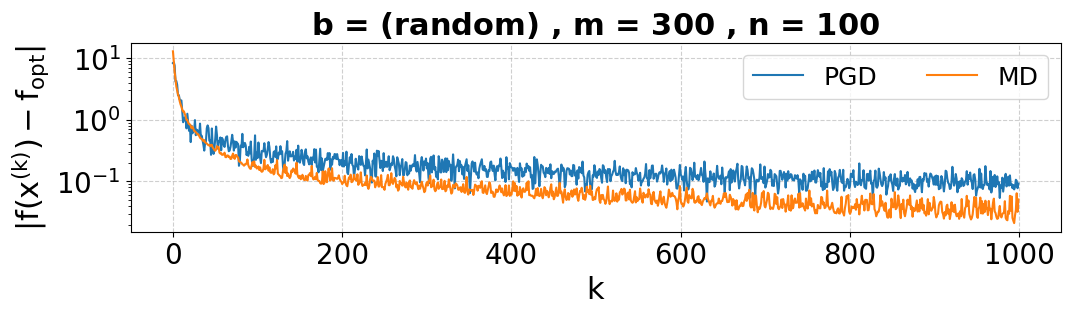

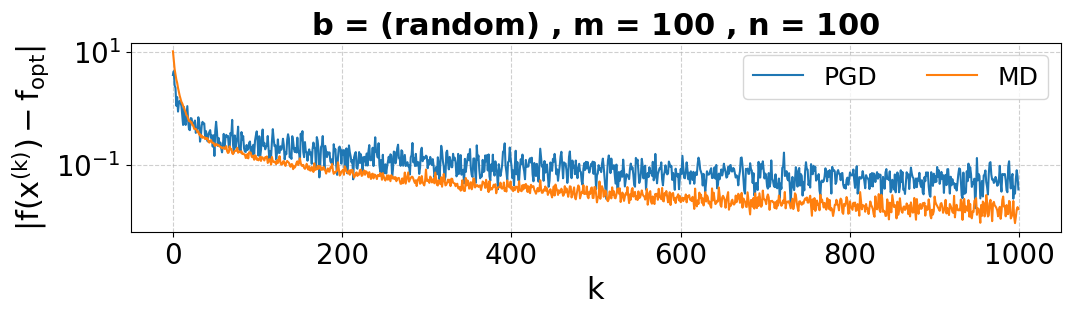

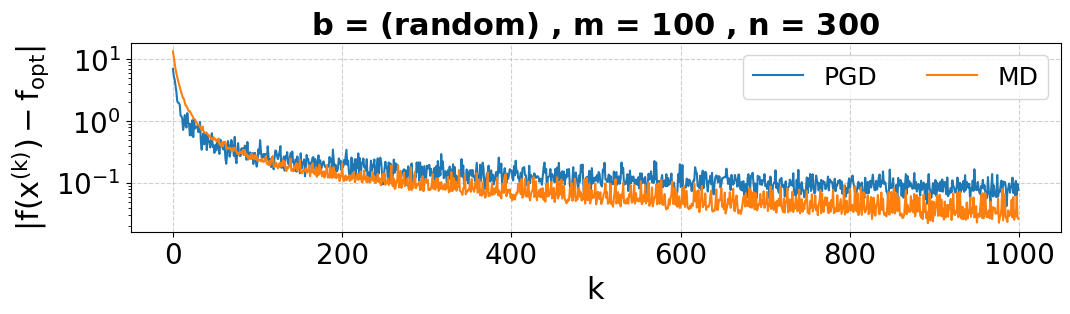

In [33]:
for m, n, k in [(300, 100, 1000), (100, 100, 1000), (100, 300, 1000)]:

    A, b = create_random_experiment(m, n)

    x_star, f_opt = CVX(A, b)


    k_subgrad_diff = projected_subgradient(A, b, f_opt, c=None, max_k=k)    
    k_mirror_diff = mirror_descent(A, b, f_opt, c=None, max_k=k)

    pdf = PdfPages(f'plots/2.7_random_{k}_{m}_{n}.pdf')
    plt.figure(figsize=(12, 3))

    list(range(len(k_subgrad_diff)))

    plt.plot(list(range(len(k_subgrad_diff))), k_subgrad_diff, label=f'PGD')
    plt.plot(list(range(len(k_mirror_diff))), k_mirror_diff, label=f'MD')

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend(ncols=2)

    # Label the axes
    plt.xlabel('$k$')
    plt.ylabel('$|f(x^{(k)}) - f_{opt}|$')

    #plt.xscale('log')
    plt.yscale('log')

    plt.title(f"$b$ = (random) , m = {m} , n = {n}")

    plt.subplots_adjust(bottom=0.22, top=0.85)

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()

## Comparison: Noisy Experiment

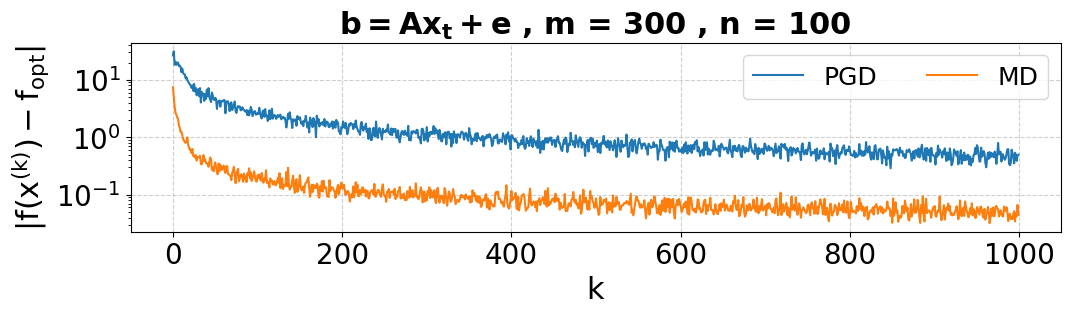

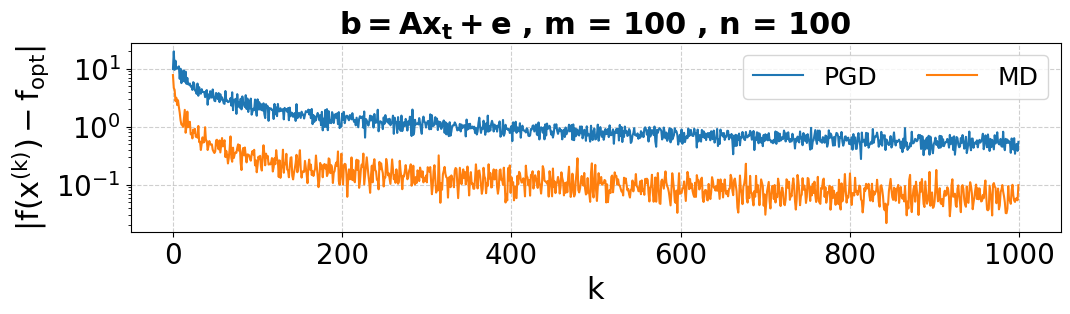

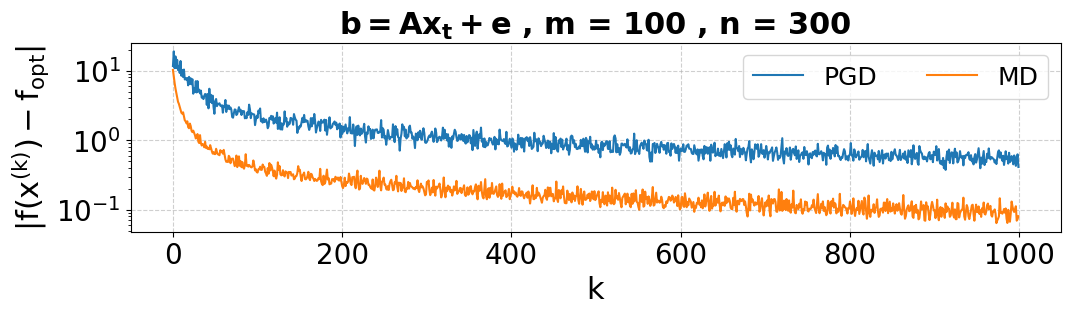

In [34]:
for m, n, k in [(300, 100, 1000), (100, 100, 1000), (100, 300, 1000)]:
    
    noise = 0.3333

    A, b = create_noisy_experiment(m, n, noise=noise)

    x_star, f_opt = CVX(A, b)


    k_subgrad_diff = projected_subgradient(A, b, f_opt, c=None, max_k=k)    
    k_mirror_diff = mirror_descent(A, b, f_opt, c=None, max_k=k)

    pdf = PdfPages(f'plots/2.7_noisy_{k}_{m}_{n}.pdf')
    plt.figure(figsize=(12, 3))

    list(range(len(k_subgrad_diff)))

    plt.plot(list(range(len(k_subgrad_diff))), k_subgrad_diff, label=f'PGD')
    plt.plot(list(range(len(k_mirror_diff))), k_mirror_diff, label=f'MD')

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend(ncols=2)

    # Label the axes
    plt.xlabel('$k$')
    plt.ylabel('$|f(x^{(k)}) - f_{opt}|$')

    #plt.xscale('log')
    plt.yscale('log')

    plt.title(f"$b = A x_t + e$ , m = {m} , n = {n}")

    plt.subplots_adjust(bottom=0.22, top=0.85)

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()